In [ ]:
from google.colab import files
uploaded = files.upload()

Saving realistic_ocean_climate_dataset.csv to realistic_ocean_climate_dataset (1).csv


In [ ]:
import io
import pandas as pd
my_df= pd.read_csv(io.BytesIO(uploaded['realistic_ocean_climate_dataset (1).csv']))

In [ ]:
my_df['Bleaching Severity']=my_df['Bleaching Severity'].fillna('None')
my_df.head()

,Date,Location,Latitude,Longitude,SST (°C),pH Level,Bleaching Severity,Species Observed,Marine Heatwave
0,2015-01-01,Red Sea,20.0248,38.4931,29.47,8.107,None,106,False
1,2015-01-07,Great Barrier Reef,-18.2988,147.7782,29.65,8.004,High,116,False
2,2015-01-14,Caribbean Sea,14.9768,-75.0233,28.86,7.947,High,90,False
3,2015-01-20,Great Barrier Reef,-18.3152,147.6486,28.97,7.995,Medium,94,False
4,2015-01-27,Galápagos,-0.8805,-90.9769,28.60,7.977,None,110,False


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as n
import torch.optim as optim

In [ ]:
 # Create a Model Class that inherits nn.Module
class Model(nn.Module):
  # Input layer(2 feacture - SST (°C), pH Level)
  #--> Hidden Layer1 (some number of neurons)
  #--> Hidden Layer2 (some number of neurons)
  #--> output(Bleaching Severity for which None = 0, Low = 1, Medium = 2, High = 3)
  def __init__(self,in_feactures=2, h1=150, h2=100, h3=80, h4=50, out_feactures=4 ):
    super().__init__() #initiate our nn.Module
    self.fc1 = nn.Linear(in_feactures , h1)
    self.fc2 = nn.Linear(h1,h2)
    self.out = nn.Linear(h2, out_feactures)
  def forward(self,x):
   x = F.relu(self.fc1(x))
   x = F.relu(self.fc2(x))
   x = self.out(x)
   return x

In [ ]:
#Pick a manual seed for randomization
torch.manual_seed(50)

In [ ]:
#Create an instance of model
model = Model()

In [ ]:
print(my_df.columns)

Index(['Date', 'Location', 'Latitude', 'Longitude', 'SST (°C)', 'pH Level',
       'Bleaching Severity', 'Species Observed', 'Marine Heatwave'],
      dtype='object')


In [ ]:
my_df['Bleaching Severity'] = my_df['Bleaching Severity'].replace('None',0)
my_df['Bleaching Severity'] = my_df['Bleaching Severity'].replace('Low',1)
my_df['Bleaching Severity'] = my_df['Bleaching Severity'].replace('Medium',2)
my_df['Bleaching Severity'] = my_df['Bleaching Severity'].replace('High',3)

In [ ]:
my_df.head()

,Date,Location,Latitude,Longitude,SST (°C),pH Level,Bleaching Severity,Species Observed,Marine Heatwave
0,2015-01-01,Red Sea,20.0248,38.4931,29.47,8.107,0,106,False
1,2015-01-07,Great Barrier Reef,-18.2988,147.7782,29.65,8.004,3,116,False
2,2015-01-14,Caribbean Sea,14.9768,-75.0233,28.86,7.947,3,90,False
3,2015-01-20,Great Barrier Reef,-18.3152,147.6486,28.97,7.995,2,94,False
4,2015-01-27,Galápagos,-0.8805,-90.9769,28.60,7.977,0,110,False


In [ ]:
# Train Test spliT. Set X,y and converting X and y to numpy array by using .values
X = my_df.drop(columns=['Date', 'Bleaching Severity','Location','Latitude', 'Longitude','Marine Heatwave','Species Observed'], axis=1).values
y = my_df['Bleaching Severity'].values

from sklearn.model_selection import train_test_split
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32) # Convert X feactures to float Tensors
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
#Convert y  to  Long tensor
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

In [ ]:
print(model.parameters)

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=2, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=4, bias=True)
)>


In [ ]:
epochs = 1000
losses = []
for i in range(epochs):
  y_pred = model.forward(X_train_tensor) #prediction
  loss = criterion(y_pred, y_train) # prediction vs true
  losses.append(loss.detach().numpy()) # track losses nad convert from tensor to number
  #print every 10 epoch
  if i % 100 == 0:
    print( f' Epoch: {i} and loss :{loss}')
  # Back Propogation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

 Epoch: 0 and loss :1.3850839138031006
 Epoch: 100 and loss :1.1727712154388428
 Epoch: 200 and loss :1.0439242124557495
 Epoch: 300 and loss :0.9438678026199341
 Epoch: 400 and loss :0.8613293170928955
 Epoch: 500 and loss :0.8055977821350098
 Epoch: 600 and loss :0.7619010210037231
 Epoch: 700 and loss :0.711077094078064
 Epoch: 800 and loss :0.6834244728088379
 Epoch: 900 and loss :0.6415814757347107


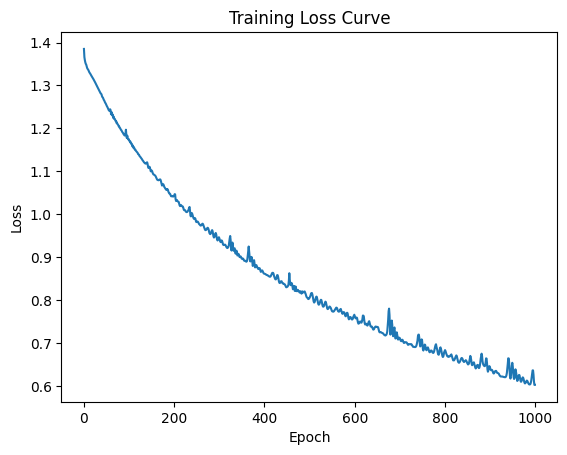

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(epochs),losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
#Evaluate Model on Test Data set
with torch.no_grad():  #turn off back propogation
   y_eval = model.forward(X_test_tensor)
   loss = criterion(y_eval, y_test)

   print(loss)

tensor(3.3422)


In [ ]:
model.eval() # set model to evaluation mode

# Lists to store all predictions and true labels across batches
all_preds = []
all_targets = []

# Variable to accumulate total loss across all batches
val_loss = 0.0

correct = 0

with torch.no_grad(): # disables gradient tracking
  for i, data in enumerate(X_test_tensor):
    data = data.unsqueeze(0)  # Add batch dimension (shape: [1, ...])
    y_val = model(data) # Forward pass to get raw model outputs(logit)
    pred = y_val.argmax().item() # Get predicted class index (highest logit)
    print(f'{i+1}.) {str(y_val)} \t {y_test[i]} \t  {pred}')  # Print logits, true label, and predicted label for each sample

    # Collect predictions and true targets
    all_preds.append(pred)
    all_targets.append(y_test[i])

     # Count correct predictions
    if pred == y_test[i]:
      correct += 1

# Print total number of correct predictions
print(f'We got {correct} correct out of {len(y_test)} samples.')

# calculate accuracy
accuracy = correct / len(y_test)
print(f'Accuracy: {accuracy:.2%}')

1.) tensor([[ 0.6649,  1.6724, -0.0296, -1.8436]]) 	 2 	  1
2.) tensor([[ 1.1100, -1.3046, -0.5274,  0.5571]]) 	 0 	  0
3.) tensor([[ 0.4950, -2.1856,  1.9664, -0.3374]]) 	 3 	  2
4.) tensor([[-0.1681,  1.7525, -0.5600,  0.2369]]) 	 3 	  1
5.) tensor([[ 1.4664, -2.8716, -3.1888, -0.3651]]) 	 2 	  0
6.) tensor([[ 0.6880,  1.8994, -1.2051, -4.1526]]) 	 0 	  1
7.) tensor([[ 1.2711, -2.0654,  1.3963, -1.1911]]) 	 1 	  2
8.) tensor([[ 0.2430, -1.5668, -1.2361, -3.4991]]) 	 0 	  0
9.) tensor([[ 0.2044,  0.3854, -0.1379, -0.1102]]) 	 1 	  1
10.) tensor([[ 5.3376, -8.7319, -1.0443, -4.9340]]) 	 3 	  0
11.) tensor([[ 0.8090,  0.7689,  2.2012, -0.6012]]) 	 2 	  2
12.) tensor([[ 13.2677,   8.2250,  12.2264, -64.7490]]) 	 0 	  0
13.) tensor([[-0.8307,  2.3240,  1.1050, -2.5464]]) 	 2 	  1
14.) tensor([[  2.5805, -12.4423,  -3.5057,   6.1274]]) 	 0 	  3
15.) tensor([[ 0.8140, -1.0642, -3.5542, -1.7948]]) 	 2 	  0
16.) tensor([[ 0.1402,  0.1792, -0.4403, -1.1038]]) 	 1 	  1
17.) tensor([[-1.1069, -0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Now print classification report
class_names = ['None', 'Low', 'Medium', 'High']
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=class_names))

#Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(all_targets, all_preds))

Classification Report:
              precision    recall  f1-score   support

        None       0.30      0.46      0.37        28
         Low       0.46      0.35      0.40        31
      Medium       0.33      0.26      0.29        19
        High       0.22      0.18      0.20        22

    accuracy                           0.33       100
   macro avg       0.33      0.32      0.32       100
weighted avg       0.34      0.33      0.33       100

Confusion Matrix:
[[13  7  2  6]
 [10 11  5  5]
 [ 6  5  5  3]
 [14  1  3  4]]
